# <span style="font-family:Courier New; color:#CCCCCC">**Vaccination Data Preprocessing**</span>

In [174]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pylab
import math
import scipy.stats as stats
from sklearn.covariance import MinCovDet

warnings.filterwarnings("ignore")

## <span style="font-family:Courier New; color:#336666">**Reading and Declaring Data**</span>

In [ ]:
df = pd.read_csv("../data/raw/vaccination/COVID-19_Vaccinations_in_the_United_States_County.csv")

rows, cols = df.shape
print("Rows:", rows)
print("Columns:", cols)

Rows: 278760
Columns: 80


In [176]:
df.sample(5)

,Date,FIPS,MMWR_week,Recip_County,Recip_State,Completeness_pct,Administered_Dose1_Recip,Administered_Dose1_Pop_Pct,Administered_Dose1_Recip_5Plus,Administered_Dose1_Recip_5PlusPop_Pct,...,Census2019_18PlusPop,Census2019_65PlusPop,Bivalent_Booster_5Plus,Bivalent_Booster_5Plus_Pop_Pct,Bivalent_Booster_12Plus,Bivalent_Booster_12Plus_Pop_Pct,Bivalent_Booster_18Plus,Bivalent_Booster_18Plus_Pop_Pct,Bivalent_Booster_65Plus,Bivalent_Booster_65Plus_Pop_Pct
119132,01/18/2021,13259,3,Stewart County,GA,0.0,0,0.0,NaN,NaN,...,"5,904",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
178310,02/05/2021,20161,5,Riley County,KS,92.3,"5,354",7.2,NaN,NaN,...,"62,113",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
19583,12/19/2020,22011,51,Beauregard Parish,LA,0.0,0,0.0,NaN,NaN,...,"28,174",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
162908,01/31/2021,40041,5,Delaware County,OK,95.1,"3,634",8.4,NaN,NaN,...,"34,428",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
147146,01/26/2021,19017,4,Bremer County,IA,97.1,"1,454",5.8,NaN,NaN,...,"19,439",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### <span style="font-family:Courier New; color:#336633">**Data Selection**</span>

#### <span style="font-family:Courier New; color:#994C00">**Variables Selection**</span>

<span style="font-family:Courier New">In a first analysis of each variable, we find out some of them useless to our purpose (because they are a combination). Besides, there are 45 columns with 100% NA's. Thus, both cases justify the deletion of some variables.</span>

In [177]:
na_percentage = (df.isna().sum() / len(df)) * 100
columns_with_100_na = na_percentage[na_percentage == 100].index

print(f"Deleting {len(columns_with_100_na)} columns with more than 100% null values")
df = df.drop(columns=columns_with_100_na)

# Series variables have combined information from other columns, so they are redundant
columns_useless = ['FIPS', 'MMWR_week', 'Completeness_pct', 'Census2019_12PlusPop', 'Census2019_18PlusPop', 'Series_Complete_Pop_Pct_UR_Equity',
                   'Series_Complete_12PlusPop_Pct_UR_Equity', 'Series_Complete_18PlusPop_Pct_UR_Equity', 'Series_Complete_65PlusPop_Pct_UR_Equity',
                   'Series_Complete_Pop_Pct_SVI', 'Series_Complete_12PlusPop_Pct_SVI', 'Series_Complete_18PlusPop_Pct_SVI', 'Series_Complete_65PlusPop_Pct_SVI', 
                   'Administered_Dose1_Recip_12Plus', 'Administered_Dose1_Recip_12PlusPop_Pct', 'Series_Complete_12Plus', 'Series_Complete_12PlusPop_Pct',
                    'Administered_Dose1_Recip_18Plus', 'Administered_Dose1_Recip_18PlusPop_Pct', 'Series_Complete_18Plus', 'Series_Complete_18PlusPop_Pct'  ]

print(f"Delteing {len(columns_useless)} columns with useless information")
df = df.drop(columns=columns_useless, errors='ignore')

Deleting 45 columns with more than 100% null values
Delteing 21 columns with useless information


#### <span style="font-family:Courier New; color:#994C00">**Objects Selection**</span>

<span style="font-family:Courier New">Instances correspond to each county's vaccinations stats, ranging from 13/12/2020 to 07/03/2021. However, vaccination periods in some counties did not start that precised day or any data is recorded. Since assumtions could be strict, the cautious decision is to regard that the first vaccination day of each county is the first day we have some data. Thus, previous days data in that counties is redundant, and we can delete it.   </span>

In [178]:
# Fix variable type to float
df['Administered_Dose1_Recip'] = pd.to_numeric(df['Administered_Dose1_Recip'].astype(str).str.replace(",", ""), errors="coerce")

# Delete rows which Dose1_Total is 0
df = df[df['Administered_Dose1_Recip'] != 0]
print("Rows after deleting Dose1_Total = 0:", len(df))

Rows after deleting Dose1_Total = 0: 139384


<span style="font-family:Courier New">We can observe a reduction of neraly `50%` of the data, which means that initially most data had null valuable data (no vaccinations taken). Since the granularity of the study is State not County, we can exclude rows which more than 50% NA's, as they will be aggregated then and the effect won't be much. This way the majority of the rows will be informative.</span>

In [179]:
na_percentage = df.isna().mean(axis=1) * 100

threshold = 50
rows_with_lots_of_nas = df[na_percentage > threshold]

print(f"Deleting {len(rows_with_lots_of_nas)} rows with more than {threshold}% null values")
df = df.drop(index=rows_with_lots_of_nas.index)

Deleting 680 rows with more than 50% null values


In [180]:
def data_explore(dataframe):
    
    print("DATA EXPLORATION")
    print('*'*70)
    print("Shape of dataset : ", dataframe.shape)
    print('*'*70)
    print(dataframe.info())
    print('*'*70)
    print("STATISTICAL ANALYSIS OF NUMERICAL DATA")
    print('*'*70)
    print(dataframe.describe().T)
    print('*'*70)
    print("STATISTICAL ANALYSIS OF CATEGORICAL DATA")
    print('*'*70)
    print(dataframe.describe(exclude = ['float', 'int64']).T)
    print('*'*70)
    print("MISSING VALUES")
    print('*'*70)
    na_counts = dataframe.isnull().sum().sort_values(ascending = False)
    print(na_counts[na_counts > 0])
    print('*'*70)
    print("MISSING VALUES IN %")
    print('*'*70)
    print(round(100* na_counts[na_counts > 0]/len(dataframe), 3))
    print('*'*70)
    
data_explore(df)

DATA EXPLORATION
**********************************************************************
Shape of dataset :  (138704, 14)
**********************************************************************
<class 'pandas.core.frame.DataFrame'>
Index: 138704 entries, 6678 to 278759
Data columns (total 14 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   Date                                    138704 non-null  object 
 1   Recip_County                            138704 non-null  object 
 2   Recip_State                             138704 non-null  object 
 3   Administered_Dose1_Recip                138534 non-null  float64
 4   Administered_Dose1_Pop_Pct              138704 non-null  float64
 5   Administered_Dose1_Recip_65Plus         138470 non-null  object 
 6   Administered_Dose1_Recip_65PlusPop_Pct  138704 non-null  float64
 7   Series_Complete_Yes                     138704 non-null  object 

### <span style="font-family:Courier New; color:#336633">**Variable Coding and Recoding**</span>

<span style="font-family:Courier New">The first step is to ensure proper variable types.</span>

In [181]:
df.dtypes

Date                                       object
Recip_County                               object
Recip_State                                object
Administered_Dose1_Recip                  float64
Administered_Dose1_Pop_Pct                float64
Administered_Dose1_Recip_65Plus            object
Administered_Dose1_Recip_65PlusPop_Pct    float64
Series_Complete_Yes                        object
Series_Complete_Pop_Pct                   float64
Series_Complete_65Plus                     object
Series_Complete_65PlusPop_Pct             float64
SVI_CTGY                                   object
Metro_status                               object
Census2019                                 object
dtype: object

<span style="font-family:Courier New">As we can see, some numerical variables such as `Administred_Dose1_Recip` are encoded as categorical. This is because they mix float and str (e.g. 1,253 -> 1253 vaccines). The same problem is reported for the other variables, so the transformation is the same:</span>

In [182]:
to_unify_float = ['Administered_Dose1_Recip', 'Administered_Dose1_Recip_65Plus',
                  'Series_Complete_Yes',  'Series_Complete_65Plus', 'Census2019']

for col in to_unify_float:
    df[col] = pd.to_numeric(df[col].astype(str).str.replace(",", ""), errors="coerce")

<span style="font-family:Courier New">Second, some categorical variables levels are not comfortably declared.
- `Date` is in MM/DD/YYYY which can be confusal, so it is standarized to ISO 8601 -> YYYY-MM-DD <br> 
- `Recip_State` is encoded with the abbrev. of the states, which could difficult the their identification in analysis. <br>
- `SVI_CTGY` levels do not explain the meaning of the variable. </span>


In [183]:
# Convert date to ISO 8601
df['Date'] = pd.to_datetime(df['Date'])

In [184]:
# Expand state abbreviations to full names (e.g 'CA' -> 'California')

us_state_abbrev = {
    'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado',
    'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho',
    'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana',
    'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi',
    'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey',
    'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma',
    'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota',
    'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington',
    'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming', 'DC': 'District of Columbia', 'PR': 'Puerto Rico'
    }

df['Recip_State'] = df['Recip_State'].map(us_state_abbrev)

In [185]:
# Convert labels to ordered categorical type, with more interpretablity

# A score of 0.85 means the area is more vulnerable than 85% of other areas.
mapping = {
    "A": "Low", # (0.0, 0.25): "Low",
    "B": "Moderate-Low", # (0.25, 0.5): "Moderate-Low",
    "C": "Moderate-High", # (0.5, 0.75): "Moderate-High",
    "D": "High" # (0.75, 1.0): "High"
}

df["SVI_CTGY"] = df["SVI_CTGY"].replace(mapping)

# Convert to ordered categorical type
df['SVI_CTGY'] = pd.Categorical(df['SVI_CTGY'], categories=mapping.values(), ordered=True)

### <span style="font-family:Courier New; color:#336633">**Terminology Normalization and Category Reduction**</span>

In [186]:
rename_dict = {
    'Recip_State': 'State',
    'Administered_Dose1_Recip': 'Dose1_Total', # People w. at least one dose
    'Administered_Dose1_Pop_Pct': 'Dose1_Total_pct',
    #'Administered_Dose1_Recip_12Plus': 'Dose1_12Plus',
    #'Administered_Dose1_Recip_12PlusPop_Pct': 'Dose1_12Plus_pct',
    #'Administered_Dose1_Recip_18Plus': 'Dose1_18Plus',
    #'Administered_Dose1_Recip_18PlusPop_Pct': 'Dose1_18Plus_pct',
    'Administered_Dose1_Recip_65Plus': 'Dose1_65Plus',
    'Administered_Dose1_Recip_65PlusPop_Pct': 'Dose1_65Plus_pct',
    'Series_Complete_Yes': 'Complete_Total', # Complete means second dose of a two-dose vaccine
    'Series_Complete_Pop_Pct': 'Complete_Total_pct',
    #'Series_Complete_12Plus': 'Complete_12Plus',
    #'Series_Complete_12PlusPop_Pct': 'Complete_12Plus_pct',
    #'Series_Complete_18Plus': 'Complete_18Plus',
    #'Series_Complete_18PlusPop_Pct': 'Complete_18Plus_pct',
    'Series_Complete_65Plus': 'Complete_65Plus',
    'Series_Complete_65PlusPop_Pct': 'Complete_65Plus_pct',
}

# Rename the columns
df = df.rename(columns=rename_dict)

## <span style="font-family:Courier New; color:#336666">**Univariate Outliers Treatment**</span>

<span style="font-family:Courier New">Outliers treatment makes sense for numercial data, so we are going to identify it.</span>

In [187]:
def segregate_data(df):
    # divides data features by its type

    cat_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
    print('Number of categorical variables: ', len(cat_features))
    print('*'*80)
    print('Categorical variables column name:', cat_features)
    print()
    numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
    print('Number of numerical variables: ', len(numerical_features))
    print('*'*80)
    print('Numerical Variables Column: ', numerical_features)

    return cat_features, numerical_features

cat_features, num_features = segregate_data(df)

Number of categorical variables:  3
********************************************************************************
Categorical variables column name: ['Recip_County', 'State', 'Metro_status']

Number of numerical variables:  11
********************************************************************************
Numerical Variables Column:  ['Date', 'Dose1_Total', 'Dose1_Total_pct', 'Dose1_65Plus', 'Dose1_65Plus_pct', 'Complete_Total', 'Complete_Total_pct', 'Complete_65Plus', 'Complete_65Plus_pct', 'SVI_CTGY', 'Census2019']


<span style="font-family:Courier New">Most of our variables are cumulative over time. For example, `Dose1_Total_pct` is the precentage of people with a completed primary series vaccination. Thus, applying a standard outlier detection method (like IQR or z-scores) might not be the most appropiate approach. </span>

### <span style="font-family:Courier New; color:#336633">**Check for invalid decreases**</span>

In [188]:
# Count the number of unique states per county
county_state_counts = df.groupby('Recip_County')['State'].nunique(dropna=False)

# Get counties with more than 1 state
more_than_1_states = county_state_counts[county_state_counts > 1].index.tolist()

print(f"{len(more_than_1_states)} counties names are repeated among states!")

381 counties names are repeated among states!


<span style="font-family:Courier New">As we can see, most of the counties names are common among states, despite they are different territorites. In this sense, we the primary key to do the analysis must be both `Recip_County` and `State`. Besides, since data is temporal we should also order by `Date`. </span>

In [189]:
# Sort the data by county, state and date
df = df.sort_values(['Recip_County', 'State', 'Date'])

<span style="font-family:Courier New">First, we are going to check that % cummulative variables draw daily increases. For example, `Dose1_Total_pct` is the % of the population of that county that is vaccinated, which only can increase through the days. </span>

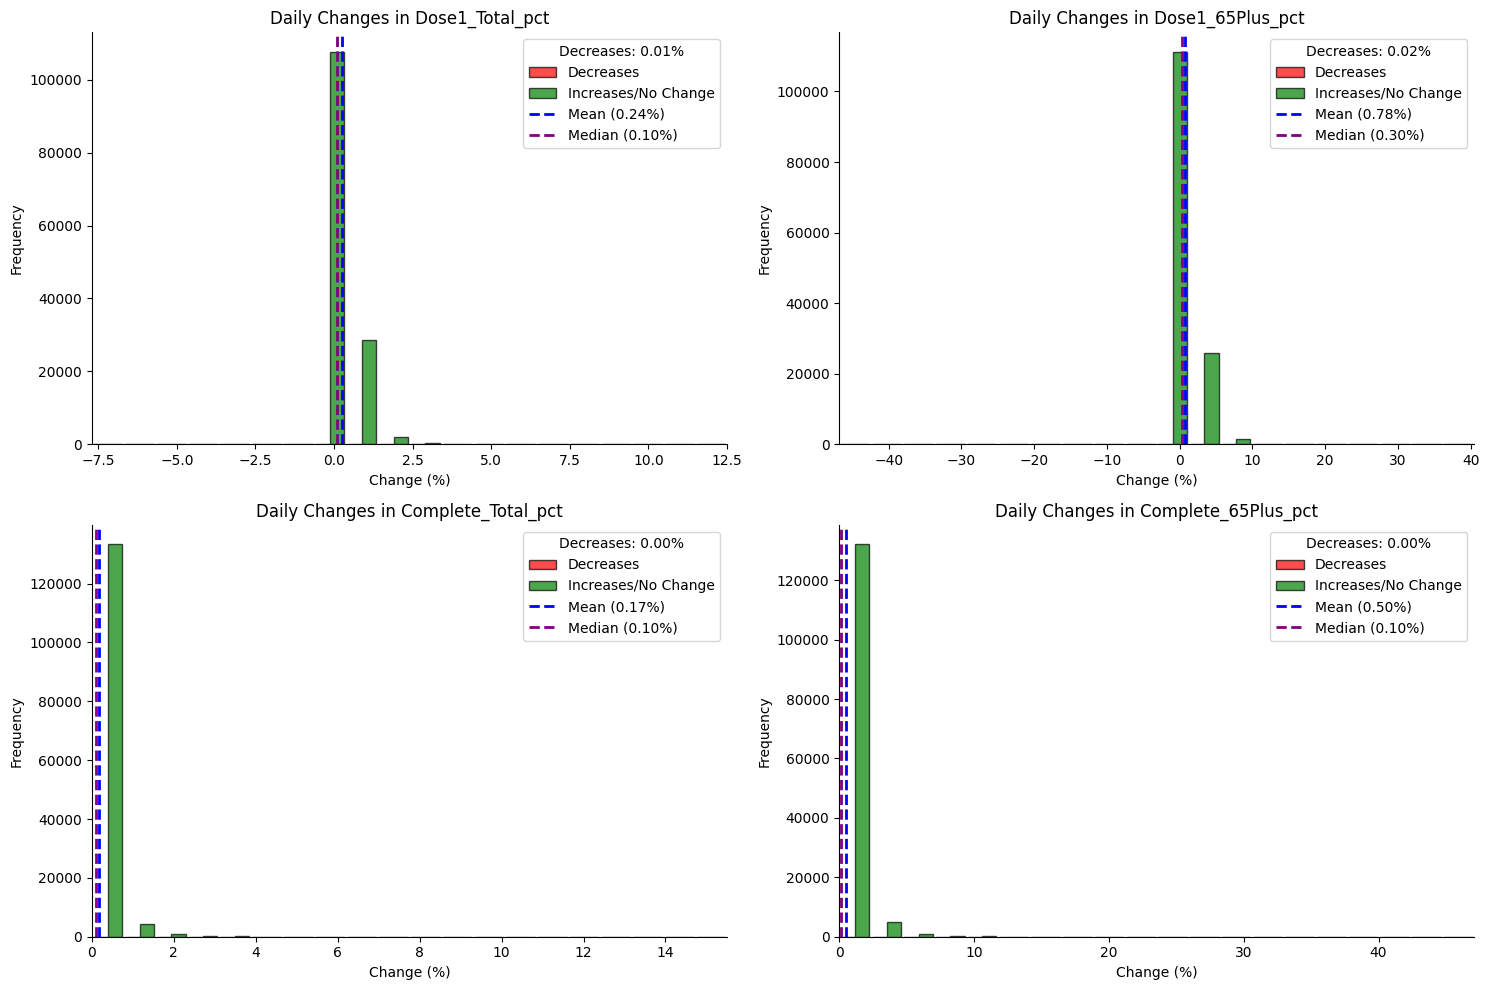

In [190]:
# Select columns with 'pct' in their name
pct_vars = [col for col in df.columns if 'pct' in col]

n_cols, n_rows = 2, math.ceil(len(pct_vars) / 2)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

grouped = df.groupby(['Recip_County', 'State'])
for ax, col in zip(axes, pct_vars):

    daily_change = grouped[col].diff().fillna(0)
    bins = np.histogram_bin_edges(daily_change, bins = 20)
    
    # Plot negative and non-negative daily changes
    ax.hist([daily_change[daily_change < 0], daily_change[daily_change >= 0]], bins=bins,
            color=['red', 'green'], alpha=0.7, edgecolor='black',
            label=['Decreases', 'Increases/No Change'], rwidth=0.9)
    
    # Plot mean and median
    mean, median = daily_change.mean(), daily_change.median()
    ax.axvline(mean, color='blue', linestyle='--', lw=2, label=f'Mean ({mean:.2f}%)')
    ax.axvline(median, color='purple', linestyle='--', lw=2, label=f'Median ({median:.2f}%)')
    
    # Set x-axis limits to match bin range so all bins are visible
    ax.set_xlim(bins[0], bins[-1])
    ax.set(title=f'Daily Changes in {col}', xlabel='Change (%)', ylabel='Frequency')
    ax.legend(title=f"Decreases: {(daily_change < 0).mean()*100:.2f}%")
    sns.despine(ax=ax)

plt.tight_layout()
plt.show()

<span style="font-family:Courier New">Second, lets analyze the other cummulative variables. </span>

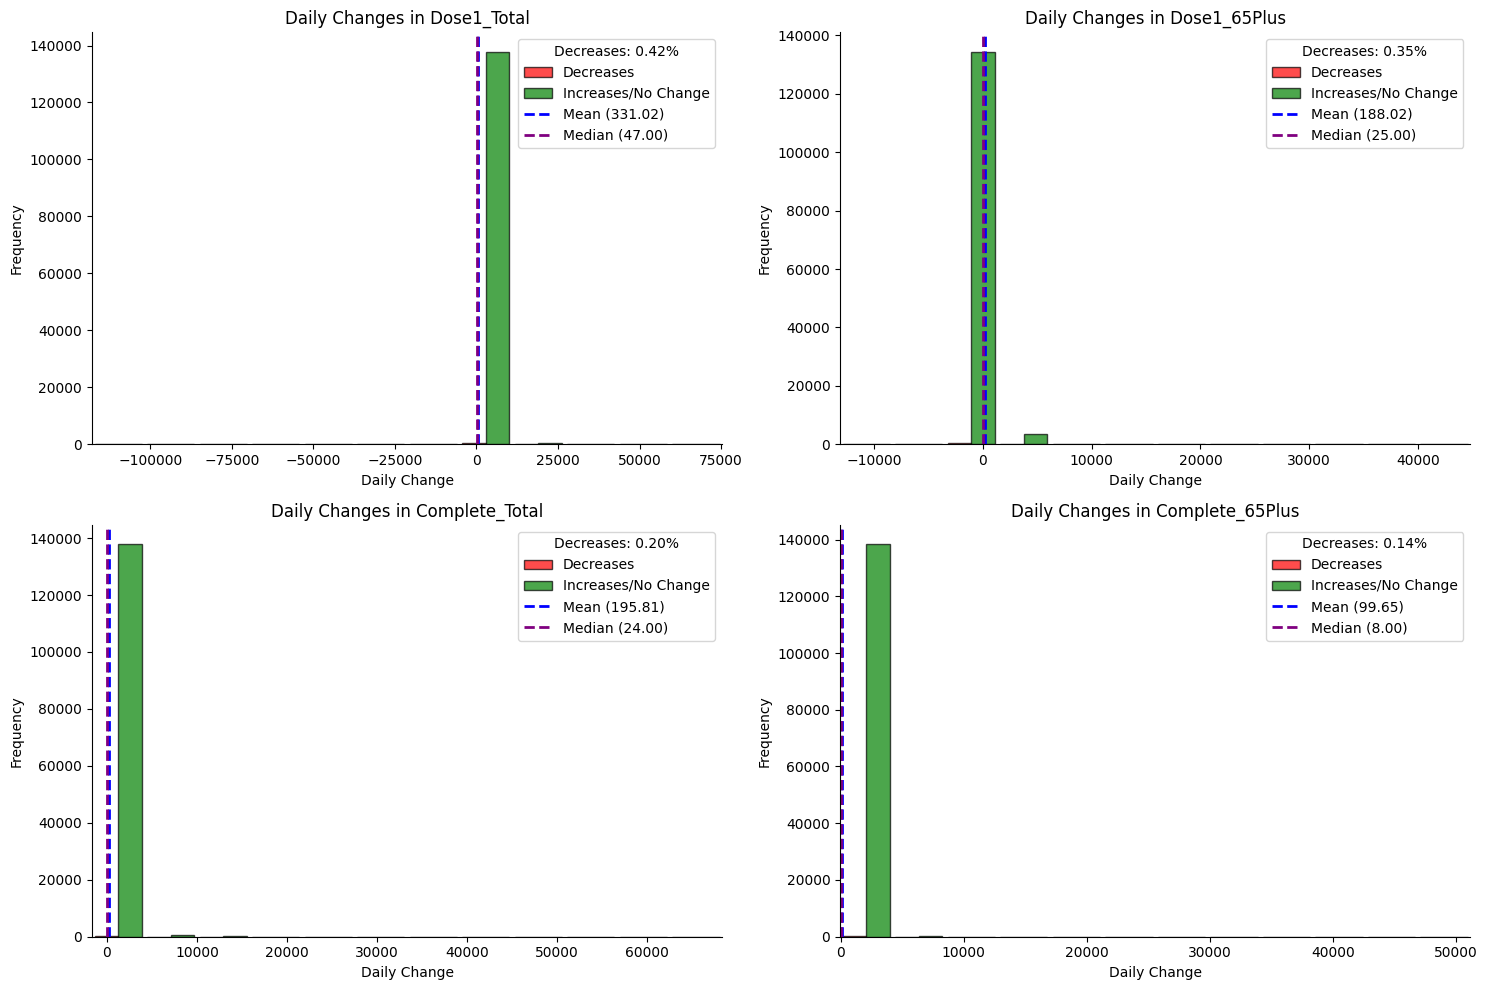

In [191]:
other_cumulative_vars = ['Dose1_Total', 'Dose1_65Plus', 'Complete_Total', 'Complete_65Plus']

n_cols, n_rows = 2, math.ceil(len(other_cumulative_vars) / 2)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 5))
axes = axes.flatten()

for ax, col in zip(axes, other_cumulative_vars):

    daily_change = grouped[col].diff().fillna(0)
    bins = np.histogram_bin_edges(daily_change, bins = 12)
    
    # Plot negative and non-negative daily changes
    ax.hist([daily_change[daily_change < 0], daily_change[daily_change >= 0]], bins=bins,
            color=['red', 'green'], alpha=0.7, edgecolor='black',
            label=['Decreases', 'Increases/No Change'], rwidth=0.9)
    
    # Plot mean and median
    mean, median = daily_change.mean(), daily_change.median()
    ax.axvline(mean, color='blue', linestyle='--', lw=2, label=f'Mean ({mean:.2f})')
    ax.axvline(median, color='purple', linestyle='--', lw=2, label=f'Median ({median:.2f})')
    
    # Set x-axis limits to match bin range so all bins are visible
    ax.set_xlim(bins[0], bins[-1])
    ax.set(title=f'Daily Changes in {col}', xlabel='Daily Change', ylabel='Frequency')
    ax.legend(title=f"Decreases: {(daily_change < 0).mean()*100:.2f}%")
    sns.despine(ax=ax)
    
plt.tight_layout()
plt.show()

<span style="font-family:Courier New">Most of these variables accomplish that they are actually incremental, so the hypotesis is respected. However, in some of them a little % of daily changes are decremental, which does not make sense. Thus, the solution will be to take the pessimistic (minimum) value. For example, if % of vaccinated people is 1 -> 1 -> 2 -> 1 -> 2 it will be converted to <br> 1 -> 1 -> 1 -> 1 -> 2

In [192]:
for col in pct_vars + other_cumulative_vars:
    
    # Correct values by propagating backward (reverse cummin)
    df[col] = df.groupby(['Recip_County', 'State'])[col].transform(
        lambda x: x[::-1].cummin()[::-1]  # Apply cummin in reverse order
    )

    # Compute daily changes after correction
    df[f'{col}_daily_change'] = df.groupby(['Recip_County', 'State'])[col].diff().fillna(0)

# Assert that any daily_change is non-negative
assert (df.filter(like='_daily_change').ge(0).all().all())

# Drop the daily_change columns
df = df.drop(columns=df.filter(like='_daily_change').columns)

### <span style="font-family:Courier New; color:#336633">**Analyze Daily Changes**</span>

<span style="font-family:Courier New">Compute daily increments and detect outliers in these changes: Rolling IQR (Adaptative to trends) </span>

<span style="font-family:Courier New">After deep analysis in this data, we find out that a high increase in vaccination rate can not determine whether a value is an outlier. <br> Thus, with the Rolling IQR we search for point where the 7-day trend is not followed, and regard it as outlier only if more than 2.5% of <br> the County's census was vaccinated. In the best case, experience of the pandemics tell us that this value was not surpassed.  </span>

In [193]:
def detect_outliers(data, col='Dose1_Total', window_size=7):
    """Detects outliers using IQR and population thresholds. Returns processed data and outliers."""

    data = data.sort_values('Date').copy()

    # Compute daily increases
    data['daily_increase'] = data[col].diff().fillna(0)
    # Calculate rolling quantiles and upper bound
    data['rolling_Q1'] = data['daily_increase'].rolling(window=window_size, min_periods=1).quantile(0.25)
    data['rolling_Q3'] = data['daily_increase'].rolling(window=window_size, min_periods=1).quantile(0.75)
    data['rolling_upper'] = data['rolling_Q3'] + 2.5 * (data['rolling_Q3'] - data['rolling_Q1'])

    # Population-based threshold
    pop_threshold = data['Census2019'].iloc[0] * 0.025

    # Set Date as index for consistent plotting
    data.set_index('Date', inplace=True)

    # Identify outliers
    outliers_iqr = data[data['daily_increase'] > data['rolling_upper']]
    outliers_pop = data[data['daily_increase'] > pop_threshold]
    
    # Filter population outliers to those also flagged by IQR
    outliers_pop = outliers_pop[outliers_pop.index.isin(outliers_iqr.index)]

    return {
        'data': data,
        'outliers_iqr': outliers_iqr,
        'outliers_pop': outliers_pop,
        'rolling_upper': data['rolling_upper'],
        'pop_threshold': pop_threshold
    }

In [194]:
def plot_cumulative_with_outliers(state, county, df, col='Dose1_Total', window_size=7):
    """Plots cumulative values with pre-detected outliers."""

    # Filter data for the target state and county
    data = df[(df['State'] == state) & (df['Recip_County'] == county)].copy()
    if data.empty:
        print(f"No data for {county}, {state}")
        return
    
    # Detect outliers and get processed data
    results = detect_outliers(data, col, window_size)
    data = results['data']
    outliers_iqr, outliers_pop = results['outliers_iqr'], results['outliers_pop']
    rolling_upper, pop_threshold = results['rolling_upper'], results['pop_threshold']

    fig, ax1 = plt.subplots(figsize=(14, 7))
    # Plot cumulative data and outliers
    ax1.plot(data.index, data[col], color='blue', marker='o', markersize=4, label=f'Cumulative {col}')
    ax1.scatter(outliers_iqr.index, outliers_iqr[col], color='red', s=100, zorder=5, label='IQR Outliers')
    ax1.scatter(outliers_pop.index, outliers_pop[col], color='green', s=100, zorder=5, label='Population Outliers')

    # Annotate outliers
    for date in outliers_iqr.index:
        ax1.annotate(f"+{outliers_iqr.loc[date, 'daily_increase']:,.0f}\n(IQR)",
                    (date, outliers_iqr.loc[date, col]), textcoords="offset points",
                    xytext=(0, 10), ha='center', fontsize=9, color='red')
    for date in outliers_pop.index:
        ax1.annotate(f"+{outliers_pop.loc[date, 'daily_increase']:,.0f}\n(Pop)",
                    (date, outliers_pop.loc[date, col]), textcoords="offset points",
                    xytext=(0, 30), ha='center', fontsize=9, color='green')
        
    # Configure secondary axis
    ax2 = ax1.twinx()
    ax2.bar(data.index, data['daily_increase'], color='orange', alpha=0.3, width=2, label='Daily Increase')
    ax2.plot(data.index, rolling_upper, color='purple', linestyle='--', label='Rolling Upper Bound')
    ax2.axhline(pop_threshold, color='green', linestyle='--', label='2.5% Population Threshold')
    ax2.set_ylabel('Daily Increase', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')

    plt.title(f"Cumulative {col}: {county}, {state} → Census: {int(data['Census2019'].iloc[0])}")
    ax2.legend(loc='center right')
    fig.autofmt_xdate(rotation=45)
    plt.show()

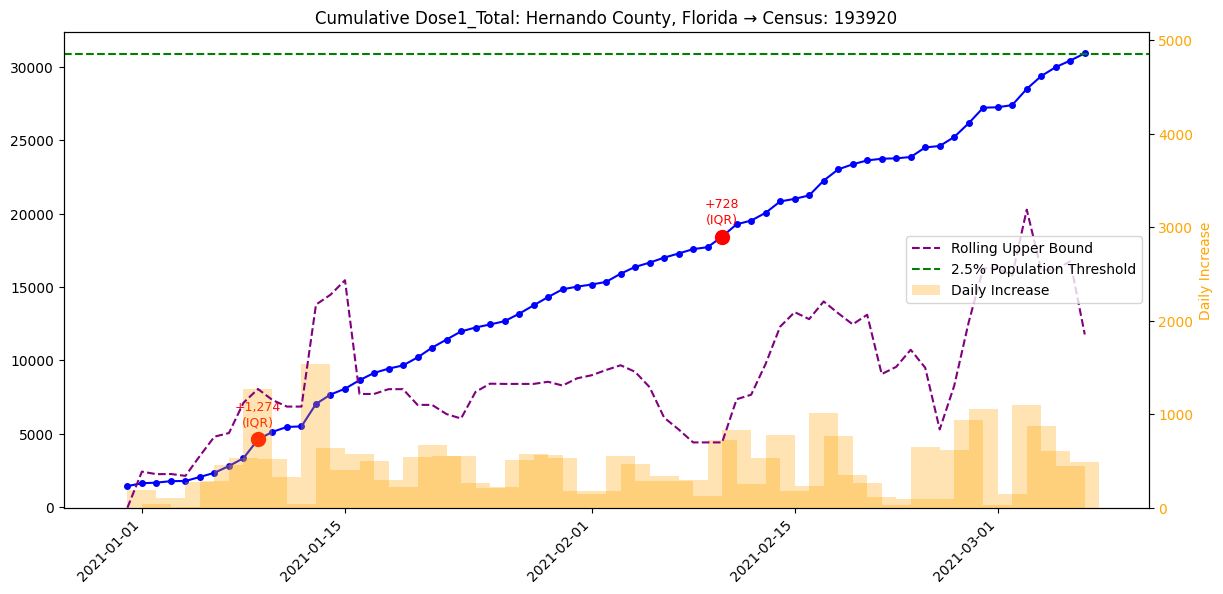

In [195]:
plot_cumulative_with_outliers(
    state="Florida", 
    county="Hernando County", 
    df=df
)

<span style="font-family:Courier New">Once we have determinated the method for outlier detection with cummulative variables, we are going to evaluate if there is any extreme value in our dataset.  </span>

In [196]:
for col in other_cumulative_vars:
    outliers = detect_outliers(df, col, window_size=7)
    iqr_col = outliers['outliers_iqr']
    pop_col = outliers['outliers_pop']
    print(f"{col}: IQR Outliers: {len(iqr_col)}, Population Outliers: {len(pop_col)}")

Dose1_Total: IQR Outliers: 8455, Population Outliers: 0
Dose1_65Plus: IQR Outliers: 8160, Population Outliers: 0
Complete_Total: IQR Outliers: 8753, Population Outliers: 0
Complete_65Plus: IQR Outliers: 8436, Population Outliers: 0


<span style="font-family:Courier New">As we can see, there are many points where the vaccination trends significantly change. Beyond being mere outliers, these are highly informative data points and can induce important conclusions. </span>

## <span style="font-family:Courier New; color:#336666">**Missing Values Treatment**</span>

In [197]:
#Mirem els missing values de totes les variables, per veure com tractar-los 
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  
missing_values_df = pd.DataFrame({'column': missing_values.index, 'missing_count': missing_values.values})
missing_values_df

,column,missing_count
0,State,799
1,Dose1_Total,969
2,Dose1_Total_pct,799
3,Dose1_65Plus,1033
4,Dose1_65Plus_pct,799
5,Complete_Total,799
6,Complete_Total_pct,799
7,Complete_65Plus,799
8,Complete_65Plus_pct,799
9,SVI_CTGY,4952


In [198]:
#Mirem quan state és missing quins altres també ho són
df_state_missing = df[df['State'].isnull()]
missing_counts = df_state_missing.isnull().sum()
missing_counts_df = pd.DataFrame({'column': missing_counts.index, 'missing_count': missing_counts.values})
missing_counts_df


,column,missing_count
0,Date,0
1,Recip_County,0
2,State,799
3,Dose1_Total,799
4,Dose1_Total_pct,799
5,Dose1_65Plus,799
6,Dose1_65Plus_pct,799
7,Complete_Total,799
8,Complete_Total_pct,799
9,Complete_65Plus,799


In [199]:
#Borrem les files on state és missing, perquè tenen missing a gairebé totes les variables
df = df.dropna(subset=['State'])

#Mirem com queden ara els valors de missings
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  
missing_values_df = pd.DataFrame({'column': missing_values.index, 'missing_count': missing_values.values})
missing_values_df


,column,missing_count
0,Dose1_Total,170
1,Dose1_65Plus,234
2,SVI_CTGY,4153
3,Metro_status,4158
4,Census2019,4107


In [200]:
# Mirem ara la variable Metro_status, ja que va lligada amb la de county
missing_metro = df[df['Metro_status'].isna()]

# Mostrar els valors únics de la columna 'county' per aquestes files
valors_county = missing_metro['Recip_County'].unique()
valors_county

array(['Unknown County', 'Valdez-Cordova Census Area'], dtype=object)

In [201]:
#Imputem manualment el valor de Non-metro en els missings que tenen de Country: Valdez-Cordova Census Area 
df.loc[(df['Recip_County'] == 'Valdez-Cordova Census Area') & (df['Metro_status'].isna()), 'Metro_status'] = 'Non-metro'

In [202]:
#Mirem ara les files on tenim unknown county
df_unknown = df[df['Recip_County'] == 'Unknown County']
missing_values_unk = df_unknown.isnull().sum()
missing_values_unk = missing_values_unk[missing_values_unk > 0]  # Filtrar només columnes amb NaNs
missing_values_df_unk = pd.DataFrame({'column': missing_values_unk.index, 'missing_count': missing_values_unk.values})
missing_values_df_unk

,column,missing_count
0,Dose1_Total,8
1,Dose1_65Plus,8
2,SVI_CTGY,4107
3,Metro_status,4107
4,Census2019,4107


In [203]:
# Borrem les files on hi ha unkown county
df = df[df['Recip_County'] != 'Unknown County']


missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  # Filtrar només columnes amb NaNs
missing_values_df = pd.DataFrame({'column': missing_values.index, 'missing_count': missing_values.values})
missing_values_df

,column,missing_count
0,Dose1_Total,162
1,Dose1_65Plus,226
2,SVI_CTGY,46


In [204]:
#Imputem els missings de les dosis amb el valor de la fila anterior (si aquesta té el mateix state i county), ja que son variables acumulatives
df['Dose1_Total'] = df.groupby(['State', 'Recip_County'])['Dose1_Total'].fillna(method='ffill')
df['Dose1_65Plus'] = df.groupby(['State', 'Recip_County'])['Dose1_65Plus'].fillna(method='ffill')

In [205]:
#En algunes files hi ha errors amb el percentatge, degut a la imputació per tant, ho recalculem 
df.loc[(df['Dose1_Total'] != 0) & (df['Dose1_Total_pct'] == 0), 'Dose1_Total_pct'] = np.nan
df.loc[df['Dose1_Total_pct'].isna(), 'Dose1_Total_pct'] = (df['Dose1_Total'] * 100 / df['Census2019'])

In [206]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  
missing_values_df = pd.DataFrame({'column': missing_values.index, 'missing_count': missing_values.values})
missing_values_df


,column,missing_count
0,Dose1_Total,55
1,Dose1_Total_pct,55
2,Dose1_65Plus,64
3,SVI_CTGY,46


In [207]:
#Pels missings que queden si el percentatge corresponent és 0, posem 0 també a la columna de recompte
df['Dose1_Total'] = df['Dose1_Total'].fillna(0)
df['Dose1_Total_pct'] = df['Dose1_Total_pct'].fillna(0)
df['Dose1_65Plus'] = df['Dose1_65Plus'].fillna(0)

In [208]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  
missing_values_df = pd.DataFrame({'column': missing_values.index, 'missing_count': missing_values.values})
missing_values_df

,column,missing_count
0,SVI_CTGY,46


In [209]:
#Tots els missings de SVI_CTGY son d'un county de new mexico, per tant imputem la moda de l'estat

def impute_mode(group):
    mode_value = group['SVI_CTGY'].mode()  # Obtenir la moda del grup
    if not mode_value.empty:  # Comprovar que no estigui buit
        group['SVI_CTGY'].fillna(mode_value[0], inplace=True)  # Imputar la moda
    return group

# Aplicar la imputació agrupant per 'State'
df = df.groupby(['State'], group_keys=False).apply(impute_mode)

In [210]:
missing_values = df.isnull().sum()
missing_values = missing_values[missing_values > 0]  
missing_values_df = pd.DataFrame({'column': missing_values.index, 'missing_count': missing_values.values})
missing_values_df

,column,missing_count


In [211]:
df.head()

,Date,Recip_County,State,Dose1_Total,Dose1_Total_pct,Dose1_65Plus,Dose1_65Plus_pct,Complete_Total,Complete_Total_pct,Complete_65Plus,Complete_65Plus_pct,SVI_CTGY,Metro_status,Census2019
100978,2021-01-12,Abbeville County,South Carolina,434.0,1.8,80.0,1.5,130.0,0.5,11.0,0.2,High,Non-metro,24527.0
103753,2021-01-13,Abbeville County,South Carolina,435.0,1.8,81.0,1.5,130.0,0.5,11.0,0.2,High,Non-metro,24527.0
106067,2021-01-14,Abbeville County,South Carolina,471.0,1.9,85.0,1.6,165.0,0.7,12.0,0.2,High,Non-metro,24527.0
108371,2021-01-15,Abbeville County,South Carolina,534.0,2.2,103.0,1.9,212.0,0.9,23.0,0.4,High,Non-metro,24527.0
113361,2021-01-16,Abbeville County,South Carolina,612.0,2.5,133.0,2.4,219.0,0.9,24.0,0.4,High,Non-metro,24527.0


## <span style="font-family:Courier New; color:#336666">**Feature Engineering**</span>

<span style="font-family:Courier New">Agreguem les dades per estats. </span>

In [212]:
# Per les variables SVI_CTGY i Metro_status definim quin percentatge de la població de cada estat pertany a cada valor de les dues variables.

df_counts_svi = df.drop_duplicates(subset=['State', 'Recip_County']).groupby(['State','SVI_CTGY'])['Census2019'].sum().reset_index().pivot(index='State', columns='SVI_CTGY', values='Census2019').fillna(0)
df_counts_svi = (df_counts_svi.div(df_counts_svi.sum(axis=1), axis=0) * 100).round(2)
df_counts_svi


SVI_CTGY,Low,Moderate-Low,Moderate-High,High
State,,,,
Alabama,8.99,15.97,43.99,31.04
Alaska,0.79,83.41,7.29,8.51
Arizona,0.00,0.00,66.96,33.04
Arkansas,0.83,23.66,36.43,39.08
California,1.87,29.21,17.24,51.69
Colorado,35.54,44.99,15.25,4.23
Connecticut,13.84,37.17,48.99,0.00
Delaware,0.00,81.43,18.57,0.00
District of Columbia,0.00,0.00,100.00,0.00


In [213]:
df_counts_metro = df.drop_duplicates(subset=['State', 'Recip_County']).groupby(['State','Metro_status'])['Census2019'].sum().reset_index().pivot(index='State', columns='Metro_status', values='Census2019').fillna(0)
df_counts_metro = (df_counts_metro.div(df_counts_metro.sum(axis=1), axis=0) * 100).round(2)
df_counts_metro


Metro_status,Metro,Non-metro
State,,
Alabama,76.84,23.16
Alaska,67.41,32.59
Arizona,95.15,4.85
Arkansas,62.72,37.28
California,98.11,1.89
Colorado,89.18,10.82
Connecticut,94.94,5.06
Delaware,100.00,0.00
District of Columbia,100.00,0.00


In [214]:
#Per les variables numèriques que no son percentatges, les sumem per agrupant per estat i dia. 

percentage_cols = [col for col in df.columns if '_pct' in col]

df_agg = df.groupby(['State', 'Date']).agg({
    **{col: 'sum' for col in df.select_dtypes(include=np.number).columns if col not in percentage_cols},
    **{col: lambda x: np.nan for col in df.select_dtypes(include=np.number).columns if col in percentage_cols}, 
    'Census2019': lambda x: np.nan,
    'SVI_CTGY': lambda x:  np.nan,
    'Metro_status': lambda x:  np.nan,
}).reset_index()

df_agg

,State,Date,Dose1_Total,Dose1_65Plus,Complete_Total,Complete_65Plus,Census2019,Dose1_Total_pct,Dose1_65Plus_pct,Complete_Total_pct,Complete_65Plus_pct,SVI_CTGY,Metro_status
0,Alabama,2021-01-07,23162.0,2857.0,1244.0,134.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Alabama,2021-01-08,23369.0,2958.0,1375.0,142.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Alabama,2021-01-09,42440.0,5687.0,5341.0,484.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Alabama,2021-01-10,43359.0,5903.0,5903.0,579.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Alabama,2021-01-11,43427.0,5936.0,5908.0,579.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123,Wyoming,2021-03-03,100955.0,56897.0,56558.0,33069.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3124,Wyoming,2021-03-04,102374.0,57395.0,58499.0,34292.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3125,Wyoming,2021-03-05,107956.0,58883.0,63585.0,37223.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3126,Wyoming,2021-03-06,108266.0,58947.0,63869.0,37313.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [215]:
#Afegim els valors que ens hem guardat de SVI_CTG i Metro_status

df_aggregated = df_agg.drop(columns=['SVI_CTGY'], errors='ignore')  
df_aggregated = df_aggregated.drop(columns=['Metro_status'], errors='ignore')  

df_aggregated = df_aggregated.merge(df_counts_svi, on='State', how='left')
df_aggregated = df_aggregated.merge(df_counts_metro, on='State', how='left')


rename_dict = {
    'Low': 'Low_SVI_CTGY','Moderate-Low': 'Moderate_Low_SVI_CTGY', 'Moderate-High': 'Moderate_High_SVI_CTGY', 'High':'High_SVI_CTGY' 
}
df_aggregated = df_aggregated.rename(columns=rename_dict)



df_aggregated.head()


,State,Date,Dose1_Total,Dose1_65Plus,Complete_Total,Complete_65Plus,Census2019,Dose1_Total_pct,Dose1_65Plus_pct,Complete_Total_pct,Complete_65Plus_pct,Low_SVI_CTGY,Moderate_Low_SVI_CTGY,Moderate_High_SVI_CTGY,High_SVI_CTGY,Metro,Non-metro
0,Alabama,2021-01-07,23162.0,2857.0,1244.0,134.0,NaN,NaN,NaN,NaN,NaN,8.99,15.97,43.99,31.04,76.84,23.16
1,Alabama,2021-01-08,23369.0,2958.0,1375.0,142.0,NaN,NaN,NaN,NaN,NaN,8.99,15.97,43.99,31.04,76.84,23.16
2,Alabama,2021-01-09,42440.0,5687.0,5341.0,484.0,NaN,NaN,NaN,NaN,NaN,8.99,15.97,43.99,31.04,76.84,23.16
3,Alabama,2021-01-10,43359.0,5903.0,5903.0,579.0,NaN,NaN,NaN,NaN,NaN,8.99,15.97,43.99,31.04,76.84,23.16
4,Alabama,2021-01-11,43427.0,5936.0,5908.0,579.0,NaN,NaN,NaN,NaN,NaN,8.99,15.97,43.99,31.04,76.84,23.16


In [216]:
#Calculem el valor de census de cada estat i l'afegim.

df_census_state = (df.drop_duplicates(subset=['State', 'Recip_County']) .groupby('State', as_index=False)['Census2019'].sum())

df_aggregated = df_aggregated.drop(columns=['Census2019'], errors='ignore')  
df_aggregated = df_aggregated.merge(df_census_state, on='State', how='left')  

df_aggregated


,State,Date,Dose1_Total,Dose1_65Plus,Complete_Total,Complete_65Plus,Dose1_Total_pct,Dose1_65Plus_pct,Complete_Total_pct,Complete_65Plus_pct,Low_SVI_CTGY,Moderate_Low_SVI_CTGY,Moderate_High_SVI_CTGY,High_SVI_CTGY,Metro,Non-metro,Census2019
0,Alabama,2021-01-07,23162.0,2857.0,1244.0,134.0,NaN,NaN,NaN,NaN,8.99,15.97,43.99,31.04,76.84,23.16,4903185.0
1,Alabama,2021-01-08,23369.0,2958.0,1375.0,142.0,NaN,NaN,NaN,NaN,8.99,15.97,43.99,31.04,76.84,23.16,4903185.0
2,Alabama,2021-01-09,42440.0,5687.0,5341.0,484.0,NaN,NaN,NaN,NaN,8.99,15.97,43.99,31.04,76.84,23.16,4903185.0
3,Alabama,2021-01-10,43359.0,5903.0,5903.0,579.0,NaN,NaN,NaN,NaN,8.99,15.97,43.99,31.04,76.84,23.16,4903185.0
4,Alabama,2021-01-11,43427.0,5936.0,5908.0,579.0,NaN,NaN,NaN,NaN,8.99,15.97,43.99,31.04,76.84,23.16,4903185.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123,Wyoming,2021-03-03,100955.0,56897.0,56558.0,33069.0,NaN,NaN,NaN,NaN,33.58,57.08,9.34,0.00,30.99,69.01,578759.0
3124,Wyoming,2021-03-04,102374.0,57395.0,58499.0,34292.0,NaN,NaN,NaN,NaN,33.58,57.08,9.34,0.00,30.99,69.01,578759.0
3125,Wyoming,2021-03-05,107956.0,58883.0,63585.0,37223.0,NaN,NaN,NaN,NaN,33.58,57.08,9.34,0.00,30.99,69.01,578759.0
3126,Wyoming,2021-03-06,108266.0,58947.0,63869.0,37313.0,NaN,NaN,NaN,NaN,33.58,57.08,9.34,0.00,30.99,69.01,578759.0


In [218]:
#Recalculem els percentatges de població total (Dose1_Total i Complete_Total) amb la variable Census2019
df_aggregated['Dose1_Total_pct'] = (df_aggregated['Dose1_Total'] * 100) / df_aggregated['Census2019']
df_aggregated['Complete_Total_pct'] = (df_aggregated['Complete_Total'] * 100) / df_aggregated['Census2019']

df_aggregated.replace([np.inf, -np.inf], np.nan, inplace=True)

df_aggregated = df_aggregated[['State', 'Date', 'Dose1_Total', 'Dose1_Total_pct', 'Dose1_65Plus', 'Complete_Total','Complete_Total_pct', 'Complete_65Plus', 'Census2019', 'Low_SVI_CTGY', 'Moderate_Low_SVI_CTGY', 'Moderate_High_SVI_CTGY', 'High_SVI_CTGY', 'Metro', 'Non-metro']]


In [219]:
#Afegim una columna amb les dades de població major de 65 anys en el 2019, hem trobat la informació per Internet.

data_65 = {
    "State": [
        "Alabama", "Alaska", "Arizona", "Arkansas", "California", "Colorado", "Connecticut", "Delaware",
        "District of Columbia", "Florida", "Georgia", "Hawaii", "Idaho", "Illinois", "Indiana", "Iowa",
        "Kansas", "Kentucky", "Louisiana", "Maine", "Maryland", "Massachusetts", "Michigan", "Minnesota",
        "Mississippi", "Missouri", "Montana", "Nebraska", "Nevada", "New Hampshire", "New Jersey",
        "New Mexico", "New York", "North Carolina", "North Dakota", "Ohio", "Oklahoma", "Oregon",
        "Pennsylvania", "Rhode Island", "South Carolina", "South Dakota", "Tennessee", "Texas", "Utah",
        "Vermont", "Virginia", "Washington", "West Virginia", "Wisconsin", "Wyoming"
    ],
    "Census2019_65Plus": [
        854312, 90588, 1307241, 524237, 5834998, 845378, 629032, 189638, 87537, 4498198,
        1523192, 269470, 288617, 2045361, 1084472, 553575, 477996, 754559, 742194, 285978,
        959887, 1172293, 1766409, 921491, 486804, 1057943, 207909, 312295, 498219, 253147,
        1475075, 377730, 3295968, 1750935, 120177, 2043548, 635222, 767496, 2388218, 187155,
        935538, 153799, 1138965, 3738727, 365198, 125201, 1358336, 1207685, 367400, 1019896, 98789
    ]
}

df_5 = pd.DataFrame(data_65)

#Recalculem els percentatges de Dose1_65Plus i Complette_65Plus amb la variable Census2019_65Plus
df_aggregated = df_aggregated.merge(df_5, on='State', how='left')  
df_aggregated['Dose1_65Plus_pct'] = (df_aggregated['Dose1_65Plus'] * 100) / df_aggregated['Census2019_65Plus']
df_aggregated['Complete_65Plus_pct'] = (df_aggregated['Complete_65Plus'] * 100) / df_aggregated['Census2019_65Plus']

df_aggregated


,State,Date,Dose1_Total,Dose1_Total_pct,Dose1_65Plus,Complete_Total,Complete_Total_pct,Complete_65Plus,Census2019,Low_SVI_CTGY,Moderate_Low_SVI_CTGY,Moderate_High_SVI_CTGY,High_SVI_CTGY,Metro,Non-metro,Census2019_65Plus,Dose1_65Plus_pct,Complete_65Plus_pct
0,Alabama,2021-01-07,23162.0,0.472387,2857.0,1244.0,0.025371,134.0,4903185.0,8.99,15.97,43.99,31.04,76.84,23.16,854312.0,0.334421,0.015685
1,Alabama,2021-01-08,23369.0,0.476609,2958.0,1375.0,0.028043,142.0,4903185.0,8.99,15.97,43.99,31.04,76.84,23.16,854312.0,0.346244,0.016622
2,Alabama,2021-01-09,42440.0,0.865560,5687.0,5341.0,0.108929,484.0,4903185.0,8.99,15.97,43.99,31.04,76.84,23.16,854312.0,0.665682,0.056654
3,Alabama,2021-01-10,43359.0,0.884303,5903.0,5903.0,0.120391,579.0,4903185.0,8.99,15.97,43.99,31.04,76.84,23.16,854312.0,0.690965,0.067774
4,Alabama,2021-01-11,43427.0,0.885690,5936.0,5908.0,0.120493,579.0,4903185.0,8.99,15.97,43.99,31.04,76.84,23.16,854312.0,0.694828,0.067774
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123,Wyoming,2021-03-03,100955.0,17.443357,56897.0,56558.0,9.772289,33069.0,578759.0,33.58,57.08,9.34,0.00,30.99,69.01,98789.0,57.594469,33.474375
3124,Wyoming,2021-03-04,102374.0,17.688537,57395.0,58499.0,10.107661,34292.0,578759.0,33.58,57.08,9.34,0.00,30.99,69.01,98789.0,58.098574,34.712367
3125,Wyoming,2021-03-05,107956.0,18.653014,58883.0,63585.0,10.986438,37223.0,578759.0,33.58,57.08,9.34,0.00,30.99,69.01,98789.0,59.604814,37.679296
3126,Wyoming,2021-03-06,108266.0,18.706577,58947.0,63869.0,11.035509,37313.0,578759.0,33.58,57.08,9.34,0.00,30.99,69.01,98789.0,59.669599,37.770400


In [220]:
df_aggregated = df_aggregated[['State', 'Date', 'Dose1_Total', 'Dose1_Total_pct', 'Dose1_65Plus', 'Dose1_65Plus_pct', 'Complete_Total','Complete_Total_pct', 'Complete_65Plus', 'Complete_65Plus_pct', 'Low_SVI_CTGY', 'Moderate_Low_SVI_CTGY', 'Moderate_High_SVI_CTGY', 'High_SVI_CTGY', 'Metro', 'Non-metro', 'Census2019', 'Census2019_65Plus']]
df_aggregated

,State,Date,Dose1_Total,Dose1_Total_pct,Dose1_65Plus,Dose1_65Plus_pct,Complete_Total,Complete_Total_pct,Complete_65Plus,Complete_65Plus_pct,Low_SVI_CTGY,Moderate_Low_SVI_CTGY,Moderate_High_SVI_CTGY,High_SVI_CTGY,Metro,Non-metro,Census2019,Census2019_65Plus
0,Alabama,2021-01-07,23162.0,0.472387,2857.0,0.334421,1244.0,0.025371,134.0,0.015685,8.99,15.97,43.99,31.04,76.84,23.16,4903185.0,854312.0
1,Alabama,2021-01-08,23369.0,0.476609,2958.0,0.346244,1375.0,0.028043,142.0,0.016622,8.99,15.97,43.99,31.04,76.84,23.16,4903185.0,854312.0
2,Alabama,2021-01-09,42440.0,0.865560,5687.0,0.665682,5341.0,0.108929,484.0,0.056654,8.99,15.97,43.99,31.04,76.84,23.16,4903185.0,854312.0
3,Alabama,2021-01-10,43359.0,0.884303,5903.0,0.690965,5903.0,0.120391,579.0,0.067774,8.99,15.97,43.99,31.04,76.84,23.16,4903185.0,854312.0
4,Alabama,2021-01-11,43427.0,0.885690,5936.0,0.694828,5908.0,0.120493,579.0,0.067774,8.99,15.97,43.99,31.04,76.84,23.16,4903185.0,854312.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3123,Wyoming,2021-03-03,100955.0,17.443357,56897.0,57.594469,56558.0,9.772289,33069.0,33.474375,33.58,57.08,9.34,0.00,30.99,69.01,578759.0,98789.0
3124,Wyoming,2021-03-04,102374.0,17.688537,57395.0,58.098574,58499.0,10.107661,34292.0,34.712367,33.58,57.08,9.34,0.00,30.99,69.01,578759.0,98789.0
3125,Wyoming,2021-03-05,107956.0,18.653014,58883.0,59.604814,63585.0,10.986438,37223.0,37.679296,33.58,57.08,9.34,0.00,30.99,69.01,578759.0,98789.0
3126,Wyoming,2021-03-06,108266.0,18.706577,58947.0,59.669599,63869.0,11.035509,37313.0,37.770400,33.58,57.08,9.34,0.00,30.99,69.01,578759.0,98789.0


In [221]:
#Borrem l'estat de Puerto Rico que no és un estat dels Estats Units
df_final = df_aggregated[df_aggregated['State'] != 'Puerto Rico']


## <span style="font-family:Courier New; color:#336666">**Multivariate Outliers Treatment**</span>

      Dose1_Total  Dose1_Total_pct  Dose1_65Plus  Dose1_65Plus_pct  \
105      144563.0        19.761327       54434.0         60.089637   
106      145431.0        19.879980       54555.0         60.223208   
107      146449.0        20.019138       54635.0         60.311520   
108      148283.0        20.269840       55071.0         60.792820   
109      150572.0        20.582739       55460.0         61.222237   
...           ...              ...           ...               ...   
2022    2847033.0        14.635022     1297047.0         39.352536   
2023    2944468.0        15.135882     1342359.0         40.727307   
2024    3071250.0        15.787598     1393733.0         42.285999   
2025    3210681.0        16.504336     1450330.0         44.003158   
2026    3340064.0        17.169422     1500125.0         45.513943   

      Complete_Total  Complete_Total_pct  Complete_65Plus  \
105          85446.0           11.680211          37284.0   
106          87668.0           11.983

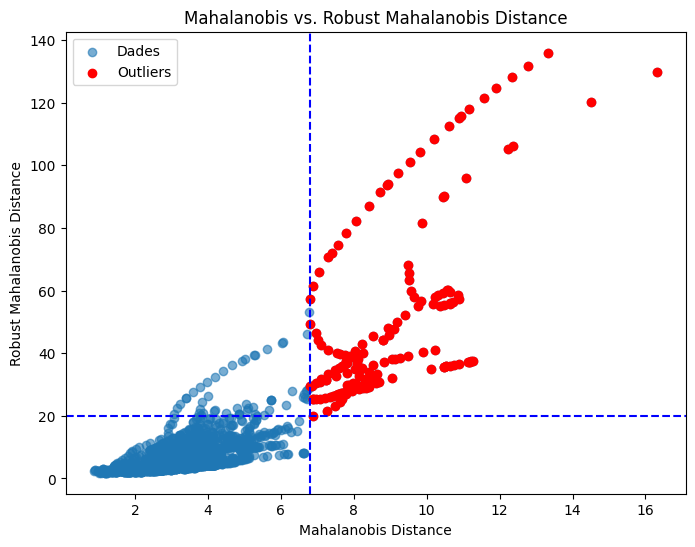

In [222]:
# Seleccionar només les columnes numèriques
dataNum = df_final.select_dtypes(include=[np.number]).copy()

# Calcular la distància de Mahalanobis
mean_vec = np.mean(dataNum, axis=0)
cov_matrix = np.cov(dataNum.T)
inv_cov_matrix = np.linalg.inv(cov_matrix)

def mahalanobis_distance(x, mean, inv_cov):
    diff = x - mean
    return np.sqrt(np.dot(np.dot(diff, inv_cov), diff.T))

dataNum['mahalanobis'] = dataNum.apply(lambda row: mahalanobis_distance(row.values, mean_vec, inv_cov_matrix), axis=1)

# Calcular p-values
df_degrees = dataNum.shape[1] - 1
dataNum['pvalue'] = 1 - stats.chi2.cdf(dataNum['mahalanobis']**2, df=df_degrees)

# Definir el nivell de significació i trobar outliers
significance_level = 0.0001
outliers = dataNum[dataNum['pvalue'] < significance_level]
indices = outliers.index

# Mostra els outliers
print(dataNum.loc[indices])

# Calcular la distància de Mahalanobis robusta (MCD)
mcd = MinCovDet()
mcd.fit(dataNum.drop(columns=['mahalanobis', 'pvalue']))
dataNum['mahalanobisRobust'] = dataNum.apply(lambda row: mahalanobis_distance(row.values[:-2], mcd.location_, np.linalg.inv(mcd.covariance_)), axis=1)

# **Visualització**
plt.figure(figsize=(8, 6))
plt.scatter(dataNum['mahalanobis'], dataNum['mahalanobisRobust'], label='Dades', alpha=0.6)
plt.scatter(dataNum.loc[indices, 'mahalanobis'], dataNum.loc[indices, 'mahalanobisRobust'], color='red', label='Outliers')
plt.axvline(x=min(dataNum.loc[indices, 'mahalanobis']), color='blue', linestyle='--')
plt.axhline(y=min(dataNum.loc[indices, 'mahalanobisRobust']), color='blue', linestyle='--')
plt.xlabel('Mahalanobis Distance')
plt.ylabel('Robust Mahalanobis Distance')
plt.legend()
plt.title('Mahalanobis vs. Robust Mahalanobis Distance')
plt.show()


In [223]:
outliers = dataNum[dataNum['mahalanobis'] > 11]
outliers

,Dose1_Total,Dose1_Total_pct,Dose1_65Plus,Dose1_65Plus_pct,Complete_Total,Complete_Total_pct,Complete_65Plus,Complete_65Plus_pct,Low_SVI_CTGY,Moderate_Low_SVI_CTGY,Moderate_High_SVI_CTGY,High_SVI_CTGY,Metro,Non-metro,Census2019,Census2019_65Plus,mahalanobis,pvalue,mahalanobisRobust
253,59902.0,0.151964,4576.0,0.078423,94.0,0.000238,10.0,0.000171,1.87,29.21,17.24,51.69,98.11,1.89,39418470.0,5834998.0,11.272054,0.0,37.498178
254,66222.0,0.167997,5391.0,0.092391,102.0,0.000259,10.0,0.000171,1.87,29.21,17.24,51.69,98.11,1.89,39418470.0,5834998.0,11.201177,0.0,37.339746
255,66847.0,0.169583,5515.0,0.094516,104.0,0.000264,10.0,0.000171,1.87,29.21,17.24,51.69,98.11,1.89,39418470.0,5834998.0,11.194728,0.0,37.325689
256,69526.0,0.176379,5711.0,0.097875,105.0,0.000266,10.0,0.000171,1.87,29.21,17.24,51.69,98.11,1.89,39418470.0,5834998.0,11.163158,0.0,37.253873
257,71099.0,0.180370,5857.0,0.100377,109.0,0.000277,10.0,0.000171,1.87,29.21,17.24,51.69,98.11,1.89,39418470.0,5834998.0,11.145099,0.0,37.213017
321,6316470.0,16.024138,3402466.0,58.311348,2930061.0,7.433218,1376218.0,23.585578,1.87,29.21,17.24,51.69,98.11,1.89,39418470.0,5834998.0,11.082649,0.0,95.981089
322,6493196.0,16.472471,3459509.0,59.288949,3045914.0,7.727124,1462234.0,25.059717,1.87,29.21,17.24,51.69,98.11,1.89,39418470.0,5834998.0,12.231091,0.0,105.227815
323,6514566.0,16.526684,3468315.0,59.439866,3056886.0,7.754959,1470211.0,25.196427,1.87,29.21,17.24,51.69,98.11,1.89,39418470.0,5834998.0,12.353814,0.0,106.143219
324,6764799.0,17.161496,3542341.0,60.708521,3227628.0,8.188111,1595772.0,27.348287,1.87,29.21,17.24,51.69,98.11,1.89,39418470.0,5834998.0,14.519556,0.0,120.238944
325,6934713.0,17.592547,3577941.0,61.318633,3328341.0,8.443608,1669253.0,28.607602,1.87,29.21,17.24,51.69,98.11,1.89,39418470.0,5834998.0,16.330010,0.0,129.641034


<span style="font-family:Courier New">Com podem veure, marca com a outliers aquells estats que tenen més població que la resta, però realment no són outliers. </span>

## <span style="font-family:Courier New; color:#336666">**Saving the Processed Dataset**</span>

In [224]:
df_final.to_csv("vacc_clean.csv", index=False)